# Projet de Simulation et Monte Carlo  
  
  Ce projet se base sur l'arcticle de Yuyang Shi et Rob Cornish : On Multilevel Monte Carlo Unbiased Gradient Estimation For Deep Latent Variable Models (2021) http://proceedings.mlr.press/v130/shi21d.html

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import random

## Partie 1 : Génération des données 
Comme dit dans l'article, nous étudions les modèles à variables latentes. pour pouvoir générer les données, nous considérerons une expérience gaussienne linéaire de la même manière que Rainforth et al. (2018) et Tucker et al. (2019)  

   On considère le modèle génératif suivant : $p_{\theta}(x,z)= \mathcal{N}(z|\theta,I)\mathcal{N}(x|z,I)$ où $x,z \in \mathbb{R^{20}}$ tel que $p_{\theta}(x)= \mathcal{N}(x|\theta,2I)$ et $p_{\theta}(z|x)= \mathcal{N}(\frac{\theta+x}{2},\frac{1}{2}I)$. La distribution de l'encodeur est $q_{\phi}(z|x)=\mathcal{N}(z|Ax+b,\frac{2}{3}I)$, où $\phi = (A,b)$. On considère une perturbation aléatoire des paramètres autour de la valeur optimale par une gaussienne centré de variance 0.01.
    

In [2]:
theta = np.random.normal(0, 1)
theta_vector = np.full(20, theta)
r = 0.6
A_true = (1/2)*np.eye(20)
b_true = theta_vector/2
X_data = multivariate_normal.rvs(theta_vector, 2*np.eye(20))
start = -6
end = 6
step = 0.025
N = 20
K_iwae = 5
print('theta = ' + str(theta))

theta = -0.6519115510619842


In [3]:
def parameter_perturbation(A, b):
    return A+np.eye(20)*np.random.normal(0, 0.01), b+np.random.normal(0, 0.01)

In [4]:
def generate_z(K, A, b, x):
    mean_z = np.dot(A, x)+b
    return np.random.multivariate_normal(mean_z, (2/3)*np.eye(20), size = 2**(K+1))

In [5]:
def q_phi(z, A, b, x):
    mean_z = np.dot(A, x)+b
    return multivariate_normal(mean_z, (2/3)*np.eye(20)).pdf(z)

In [6]:
def p_joint(z, K, x, mu):
    p = []
    mu_vector = np.full(20, mu)
    for i in range(2**(K+1)):
        p.append(multivariate_normal.pdf(z[i], mu_vector, np.eye(20))*multivariate_normal.pdf(x,z[i],np.eye(20)))
    return np.array(p)

## Partie 2 : Estimation de la vraisemblance  
  
  Dans cette partie, nous allons reproduire les estimateurs IWAE, SS, RR et SUMO cités dans l'article

### A - Log-Vraisemblance théorique de $p_{\theta}(x)$

In [7]:
def log_likelihood(x,mu):
    mu_vector = np.full(20, mu)
    return -10*np.log(2*np.pi)-10*np.log(2)-0.25*np.dot(x-mu_vector,x-mu_vector)

### B - Estimateur SS :

  #### B.1 - Création de l'estimateur

In [8]:
def SS_estimator(A, b, x, mu, N_sim):
    list_ss = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        log_w_O = log_w[1::2]
        log_w_E = log_w[::2]
        I0 = np.mean(log_w)
        l_O = logsumexp(log_w_O) - np.log(len(log_w_O))
        l_E = logsumexp(log_w_E) - np.log(len(log_w_E))
        l_OUE = logsumexp(log_w) - np.log(len(log_w))
        delta_K = l_OUE - 0.5*(l_O + l_E)
        SS = I0 + delta_K/(r*(1-r)**(K-1))
        list_ss.append(SS)
    return np.mean(list_ss)

#### B.2 - Visualisation SS

In [9]:
def visualisation_SS(A, b, x, debut, fin, pas, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    mu_list = np.arange(debut+theta, fin+theta, pas)
    list_ss_mu = []
    list_log_likelihood_mu = []
    for mu in mu_list:
        list_log_likelihood_mu.append(log_likelihood(x, mu))
        ss_estimator = SS_estimator(A_perturbed, b_perturbed, x, mu, N_sim)
        list_ss_mu.append(ss_estimator)
    return list_log_likelihood_mu, list_ss_mu, mu_list

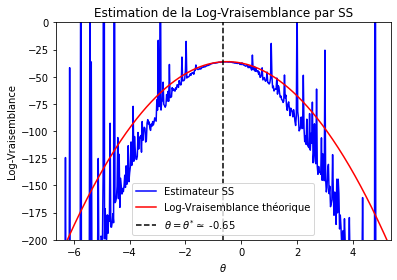

In [10]:
list_log_likelihood_mu, list_ss_mu, mu_list = visualisation_SS(A_true, b_true, X_data, start, end, step, N)

plt.clf()
plt.plot(mu_list, list_ss_mu, color='blue', label='Estimateur SS')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par SS')
plt.show()

### C - Estimateur RR

#### C.1 - Création de l'estimateur

In [11]:
def RR_estimator(A, b, x, mu, N_sim):
    list_rr = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        log_w_O = log_w[1::2]
        log_w_E = log_w[::2]
        I0 = np.mean(log_w)
        RR = I0
        for l in range(K+1):
            l_O = logsumexp(log_w_O[:2**l]) - np.log(len(log_w_O[:2**l]))
            l_E = logsumexp(log_w_E[:2**l]) - np.log(len(log_w_E[:2**l]))
            l_OUE = logsumexp(log_w[:2**(l+1)]) - np.log(len(log_w[:2**(l+1)]))
            delta_l = l_OUE - 0.5*(l_O + l_E)
            RR += delta_l/((1-r)**max(l-1,0))
        list_rr.append(RR)
    return np.mean(list_rr)

#### C.2 - Visualisation RR

In [12]:
def visualisation_RR(A, b, x, debut, fin, pas, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    mu_list = np.arange(debut+theta, fin+theta, pas)
    list_rr_mu = []
    list_log_likelihood_mu = []
    for mu in mu_list:
        list_log_likelihood_mu.append(log_likelihood(x, mu))
        rr_estimator = RR_estimator(A_perturbed, b_perturbed, x, mu, N_sim)
        list_rr_mu.append(rr_estimator)
    return list_log_likelihood_mu, list_rr_mu, mu_list

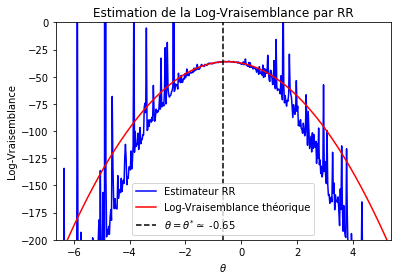

In [13]:
list_log_likelihood_mu, list_rr_mu, mu_list = visualisation_RR(A_true, b_true, X_data, start, end, step, N)

plt.clf()
plt.plot(mu_list, list_rr_mu, color='blue', label='Estimateur RR')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par RR')
plt.show()

### D - Estimateur IWAE

#### D.1 - Création de l'estimateur

In [14]:
def generate_z_iwae(K, A, b, x):
    mean_z = np.dot(A, x)+b
    return np.random.multivariate_normal(mean_z, (2/3)*np.eye(20), size = K)

In [15]:
def p_joint_iwae(z, K, x, mu):
    p = []
    mu_vector = np.zeros(20)+mu
    for i in range(K):
        p.append(multivariate_normal.pdf(z[i], mu_vector, np.eye(20))*multivariate_normal.pdf(x,z[i],np.eye(20)))
    return np.array(p)

In [16]:
def IWAE_estimator(A, b, x, mu, K, N_sim):
    list_IWAE = []
    for i in range(N_sim):
        Z_data = generate_z_iwae(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint_iwae(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        IWAE = logsumexp(log_w) - np.log(len(log_w))
        list_IWAE.append(IWAE)
    return np.mean(IWAE)

In [17]:
def visualisation_IWAE(A, b, x, debut, fin, pas, K, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    mu_list = np.arange(debut+theta, fin+theta, pas)
    list_iwae_mu = []
    list_log_likelihood_mu = []
    for mu in mu_list:
        list_log_likelihood_mu.append(log_likelihood(x, mu))
        iwae_estimator = IWAE_estimator(A_perturbed, b_perturbed, x, mu, K, N_sim)
        list_iwae_mu.append(iwae_estimator)
    return list_log_likelihood_mu, list_iwae_mu, mu_list

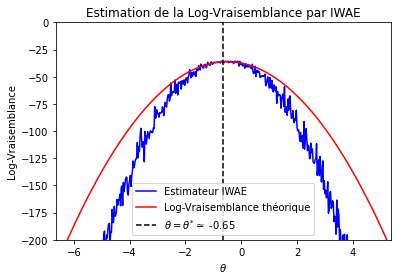

In [18]:
list_log_likelihood_mu, list_iwae_mu, mu_list = visualisation_IWAE(A_true, b_true, X_data, start, end, step, K_iwae, N)

plt.clf()
plt.plot(mu_list, list_iwae_mu, color='blue', label='Estimateur IWAE')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par IWAE')
plt.show()

### E - Estimateur SUMO

In [19]:
def generate_z_sumo(K, A, b, x):
    mean_z = np.dot(A, x)+b
    return np.random.multivariate_normal(mean_z, (2/3)*np.eye(20), size = K+2)

In [20]:
def p_joint_sumo(z, K, x, mu):
    p = []
    mu_vector = np.zeros(20)+mu
    for i in range(K+2):
        p.append(multivariate_normal.pdf(z[i], mu_vector, np.eye(20))*multivariate_normal.pdf(x,z[i],np.eye(20)))
    return np.array(p)

In [21]:
def SUMO_estimator(A, b, x, mu, N_sim):
    list_sumo = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z_sumo(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint_sumo(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        I0 = np.mean(log_w)
        SUMO = I0
        for k in range(K+1):
            l2 = logsumexp(log_w[:k+2]) - np.log(len(log_w[:k+2]))
            l1 = logsumexp(log_w[:k+1]) - np.log(len(log_w[:k+1]))
            SUMO += (l2-l1)/((1-r)**max(k-1,0))
        list_sumo.append(SUMO)
    return np.mean(list_sumo)

In [22]:
def visualisation_SUMO(A, b, x, debut, fin, pas, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    mu_list = np.arange(debut+theta, fin+theta, pas)
    list_sumo_mu = []
    list_log_likelihood_mu = []
    for mu in mu_list:
        list_log_likelihood_mu.append(log_likelihood(x, mu))
        sumo_estimator = SUMO_estimator(A_perturbed, b_perturbed, x, mu, N_sim)
        list_sumo_mu.append(sumo_estimator)
    return list_log_likelihood_mu, list_rr_mu, mu_list

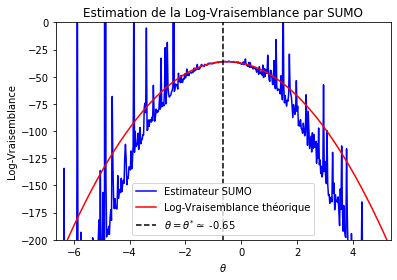

In [24]:
list_log_likelihood_mu, list_sumo_mu, mu_list = visualisation_SUMO(A_true, b_true, X_data, start, end, step, N)

plt.clf()
plt.plot(mu_list, list_sumo_mu, color='blue', label='Estimateur SUMO')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par SUMO')
plt.show()

### E - Estimateur SUMO 2

In [25]:
def SUMO_estimator2(A, b, x, mu, N_sim):
    list_sumo = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        I0 = np.mean(log_w)
        SUMO = I0
        for k in range(K+1):
            l2 = logsumexp(log_w[:2**(k+1)]) - np.log(len(log_w[:2**(k+1)]))
            l1 = logsumexp(log_w[:2**k]) - np.log(len(log_w[:2**k]))
            SUMO += (l2-l1)/((1-r)**max(k-1,0))
        list_sumo.append(SUMO)
    return np.mean(list_sumo)

In [26]:
def visualisation_SUMO2(A, b, x, debut, fin, pas, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    mu_list = np.arange(debut+theta, fin+theta, pas)
    list_sumo_mu = []
    list_log_likelihood_mu = []
    for mu in mu_list:
        list_log_likelihood_mu.append(log_likelihood(x, mu))
        sumo_estimator = SUMO_estimator2(A_perturbed, b_perturbed, x, mu, N_sim)
        list_sumo_mu.append(sumo_estimator)
    return list_log_likelihood_mu, list_rr_mu, mu_list

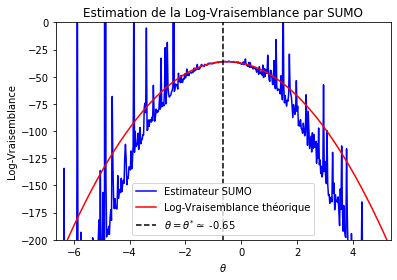

In [27]:
list_log_likelihood_mu, list_sumo_mu, mu_list = visualisation_SUMO2(A_true, b_true, X_data, start, end, step, N)

plt.clf()
plt.plot(mu_list, list_sumo_mu, color='blue', label='Estimateur SUMO')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par SUMO')
plt.show()